In [1]:
import argparse, os, time
import pandas as pd
import geopandas as gpd
import polars as pl
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter, FuncFormatter
import matplotlib.patheffects as path_effects
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from collections import defaultdict
import warnings
from tqdm import tqdm
import pickle
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tqdm.pandas()
warnings.filterwarnings("ignore")

In [2]:
year = 20
donors_csv = f"./output/donors_recip_agg_pred_lastname_trunc.csv"

In [3]:
donors = pd.read_csv(donors_csv)
donors.head(10)

,contrib_id,recip_id,name_new,realcode,gender,occupation,city,state,total_donated,donation_count,...,seat,ran_general,type,cmte_id,pac_short,recip_id_pac,cand_id,recip_is_pac,dem_ratio,level
0,1,C60000015,republican national committee republican natio...,B1500,,NaN,WASHINGTON,DC,77820848.0,4793,...,NaN,NaN,NaN,C60000015,RNC/Repub National State Elections Cmte,C60000015,NaN,True,NaN,PAC
1,,N00000802,,Z9000,,NaN,NaN,,72634500.0,75,...,PRES,,O,NaN,NaN,NaN,NaN,False,-0.420059,President
2,1,C60000262,dnc general fund dnc general fund,K1000,,NaN,WASHINGTON,DC,40192970.0,2247,...,NaN,NaN,NaN,C60000262,DNC/Non-Federal Corporate,C60000262,NaN,True,NaN,PAC
3,1,C60000205,at&t at&t,B1500,,NaN,WASHINGTON,DC,32889365.0,9112,...,NaN,NaN,NaN,C60000205,NRCC/Non-Federal,C60000205,NaN,True,NaN,PAC
4,1,C60000148,at&t at&t,H4300,,NaN,WASHINGTON,DC,30116512.0,2572,...,NaN,NaN,NaN,C60000148,NRSC/Non-Federal,C60000148,NaN,True,NaN,PAC
5,1,C60000080,dccc nonfederal receipts-c dccc nonfederal rec...,Z9100,,NaN,WASHINGTON,DC,22149421.0,545,...,NaN,NaN,NaN,C60000080,DCCC/Non-Federal Account 1,C60000080,NaN,True,NaN,PAC
6,1,C60000619,bacardi-martini usa inc bacardi-martini usa inc,K1000,,NaN,WASHINGTON,DC,20752086.0,963,...,NaN,NaN,NaN,C60000619,DSCC/Non-Federal Corporate,C60000619,NaN,True,NaN,PAC
7,1,C60001450,mci worldcom mci worldcom,K1000,,NaN,WASHINGTON,DC,16237657.0,1559,...,NaN,NaN,NaN,C60001450,DCCC/Non-Federal Account 1,C60001450,NaN,True,NaN,PAC
8,1,C60000247,i b e w educational committee i b e w educatio...,LB100,,NaN,WASHINGTON,DC,13487450.0,217,...,NaN,NaN,NaN,C60000247,DNC/Non-Federal General,C60000247,NaN,True,NaN,PAC
9,1,C60000288,dccc nonfederal receipts-i dccc nonfederal rec...,Z9100,,NaN,WASHINGTON,DC,9651243.0,48,...,NaN,NaN,NaN,C60000288,DCCC/Non-Federal Account 5,C60000288,NaN,True,NaN,PAC


In [4]:
donors["level"].value_counts()

level
PAC          14768809
House        13329955
President     4432438
Unknown         18200
Name: count, dtype: int64

In [5]:
donors["party"].value_counts()

party
D    10233961
R     8405383
I      310080
3       39094
L       17500
U         137
Name: count, dtype: int64

In [6]:
donors[["recip_id", "name_y"]].value_counts()

recip_id   name_y                               
C00003418  Republican National Cmte                 1593676
C00694323  WinRed                                    994887
N00001669  Joe Biden (D)                             863872
N00023864  Donald Trump (R)                          819862
C00010603  DNC Services Corp                         809651
                                                     ...   
C00714139  Dump the Chump                                 1
C00714113  Big Tree PAC                                   1
C00714097  Blake Harrison Victory Fund                    1
C00713834  Outraise PAC                                   1
C00782490  Americans for Conservative Government          1
Name: count, Length: 34047, dtype: int64

In [7]:
donors["seat"].value_counts()

seat
PRES    4432438
VTS1     493932
GAS2     401963
TXS2     256932
MAS1     241500
         ...   
CA00          5
TX00          5
SC00          3
ASAS          2
              1
Name: count, Length: 578, dtype: int64

In [8]:
donors[donors["indian"] == True]["seat"].value_counts()

seat
PRES    47389
IL08     6780
VTS1     6062
NYS1     4376
GAS2     3360
        ...  
PA20        3
OK06        1
OH19        1
NY31        1
MI16        1
Name: count, Length: 571, dtype: int64

In [9]:
donors[donors["indian"] == True].sort_values(by="total_donated", ascending=False).head(10)[["contrib_id", "recip_id", "name_new", "realcode", "gender", "occupation", "city", "state", "total_donated", "name_y", "party", "seat", "type"]]

,contrib_id,recip_id,name_new,realcode,gender,occupation,city,state,total_donated,name_y,party,seat,type
16285911,h3003465387,N00041034,shiva dr ayyadurai,Z9000,M,CHAIRMAN & CEO,CAMBRIDGE,MA,4817653.0,Shiva Ayyadurai (I),I,MAS1,C
26570010,U0000004761,C00473918,nishad singh,F2800,M,DIRECTOR OF ENGINEERING,"NEW PROVIDENCE, BAHAMAS",NaN,2250000.0,Women Vote!,NaN,NaN,NaN
26570051,U0000004761,C00484642,nishad singh,F2800,M,DIRECTOR OF ENGINEERING,LOS ALTOS HILLS,CA,2000000.0,Senate Majority PAC,D,NaN,NaN
12402789,U0000003169,C00495861,philip r munger,F7000,M,INVESTOR,NEW YORK,NY,1850000.0,Priorities USA Action,NaN,NaN,NaN
26570199,U0000004761,C00476978,nishad singh,F2800,M,DIRECTOR OF ENGINEERING,NASSAU,NaN,1100000.0,LGBTQ Victory Fund,NaN,NaN,NaN
19433829,h3003465387,N00041034,shiva ayyadurai,Z9000,U,CHAIRMAN & CEO,BELMONT,MA,1044900.0,Shiva Ayyadurai (R),R,MAS2,C
26570232,U00000047351,C00486845,reuben munger,F2500,M,MANAGING PARTNER,BOULDER,CO,1002000.0,LCV Victory Fund,NaN,NaN,NaN
19433886,U00000033011,C00492140,vinod khosla,F2500,M,FOUNDER,SAN JOSE,CA,1000000.0,American Bridge 21st Century,NaN,NaN,NaN
19433863,U0000004761,C00669259,nishad singh,F2800,M,DIRECTOR OF ENGINEERING,SAN FRANCISCO,CA,1000000.0,Future Forward USA,D,NaN,NaN
12402885,U0000004554,C00582841,vivek garipalli,H2100,M,EXECUTIVE,WILMINGTON,DE,1000000.0,Coalition For Progress,NaN,NaN,NaN


In [10]:
population = pd.read_csv("./data/aapi_population.csv")
population.head(10)

,Year,Name,Code,Indian Pop,Census Pop,Share
0,2014,Alabama,AL,11754,4841799,0.242761
1,2014,Alaska,AK,0,736283,0.000000
2,2014,Arizona,AZ,39764,6730413,0.590811
3,2014,Arkansas,AR,8035,2967392,0.270776
4,2014,California,CA,607297,38596972,1.573432
5,2014,Colorado,CO,20342,5350101,0.380217
6,2014,Connecticut,CT,49204,3594524,1.368860
7,2014,Delaware,DE,13349,932487,1.431548
8,2014,District of Columbia,DC,136461,662328,20.603236
9,2014,Florida,FL,130382,19845911,0.656972


In [11]:
donors_avg = donors.groupby(['cycle', 'indian', 'party']).agg(mean=('total_donated', 'mean'), median=('total_donated', 'median')).reset_index()
donors_avg = donors_avg.pivot(index='cycle', columns=['indian', 'party'], values=['mean', 'median']).fillna(0).reset_index()
donors_avg.columns = ['cycle',
                      'mean_other_3', 'mean_other_d', 'mean_other_i', 'mean_other_l', 'mean_other_r','mean_other_u', 
                      'mean_indian_3', 'mean_indian_d', 'mean_indian_i', 'mean_indian_l', 'mean_indian_r','mean_indian_u', 
                      'median_other_3', 'median_other_d', 'median_other_i', 'median_other_l', 'median_other_r','median_other_u', 
                      'median_indian_3', 'median_indian_d', 'median_indian_i', 'median_indian_l', 'median_indian_r','median_indian_u']
donors_avg

,cycle,mean_other_3,mean_other_d,mean_other_i,mean_other_l,mean_other_r,mean_other_u,mean_indian_3,mean_indian_d,mean_indian_i,...,median_other_i,median_other_l,median_other_r,median_other_u,median_indian_3,median_indian_d,median_indian_i,median_indian_l,median_indian_r,median_indian_u
0,2000,756.295176,912.493411,699.722313,731.006993,1019.408337,515.625000,556.900000,764.205197,687.500000,...,500.0,500.0,750.0,475.0,500.0,500.0,750.0,500.0,550.0,0.0
1,2002,976.414722,855.944012,716.864706,678.303030,866.877698,0.000000,250.000000,753.113490,700.000000,...,300.0,400.0,500.0,0.0,250.0,500.0,750.0,500.0,500.0,0.0
2,2004,969.166870,1058.895116,1553.496651,816.603206,1191.098645,611.000000,624.137931,1015.060654,500.000000,...,300.0,500.0,1000.0,611.0,500.0,500.0,500.0,401.0,1000.0,0.0
3,2006,879.131181,1174.627828,1534.432185,1171.771552,1241.085740,388.750000,653.571429,1078.596210,1303.611940,...,1000.0,500.0,750.0,375.0,500.0,501.0,1000.0,500.0,500.0,0.0
4,2008,1055.278655,1235.813973,897.200806,854.561655,1360.697616,70.000000,1146.629630,1248.591061,953.448276,...,300.0,500.0,950.0,70.0,600.0,708.0,300.0,1000.0,1000.0,0.0
5,2010,1238.611271,1300.169763,1505.449280,2111.117647,1324.261603,1950.000000,2262.833333,1234.237047,1589.648045,...,750.0,500.0,500.0,1000.0,1750.0,500.0,1000.0,0.0,500.0,0.0
6,2012,643.573482,1128.155851,2375.060239,878.314672,1442.811387,1031.714286,652.631579,1118.616053,701.388889,...,500.0,500.0,500.0,500.0,250.0,500.0,500.0,500.0,500.0,250.0
7,2014,3637.929412,1642.554006,1974.321082,1213.165919,1475.193762,1330.454545,250.000000,1490.324304,1501.040816,...,500.0,500.0,750.0,500.0,250.0,750.0,1000.0,0.0,765.0,700.0
8,2016,651.402337,1038.331661,1049.819739,552.384503,1012.382194,2051.333333,721.247312,1290.539600,1085.488372,...,350.0,250.0,250.0,1005.0,500.0,500.0,500.0,250.0,500.0,0.0
9,2018,1416.781109,1508.522531,980.579887,1440.096647,1774.623269,0.000000,634.666667,1560.695638,61781.202532,...,250.0,500.0,500.0,0.0,285.5,755.0,410.0,150.0,750.0,0.0


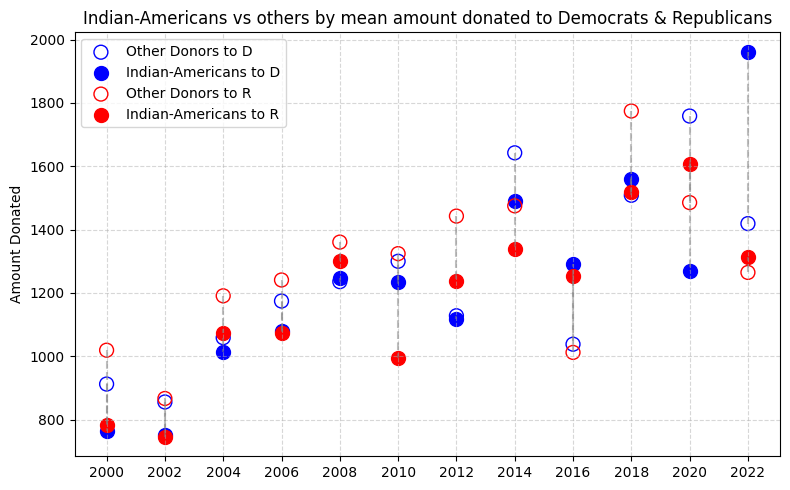

In [12]:
plt.figure(figsize=(8, 5))

cycles = pd.Series(donors_avg["cycle"]).apply(lambda x: str(x)[:4])
for cat, g1, g2 in zip(cycles, donors_avg["mean_other_d"], donors_avg["mean_indian_d"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)
for cat, g1, g2 in zip(cycles, donors_avg["mean_other_r"], donors_avg["mean_indian_r"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)

plt.scatter(cycles, donors_avg["mean_other_d"], facecolors='none', edgecolors='blue', color='blue', label='Other Donors to D', s=100)
plt.scatter(cycles, donors_avg["mean_indian_d"], color='blue', label='Indian-Americans to D', s=100)
plt.scatter(cycles, donors_avg["mean_other_r"], facecolors='none', edgecolors='red', label='Other Donors to R', s=100)
plt.scatter(cycles, donors_avg["mean_indian_r"], color='red', label='Indian-Americans to R', s=100)

plt.title(f"Indian-Americans vs others by mean amount donated to Democrats & Republicans")
plt.ylabel("Amount Donated")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

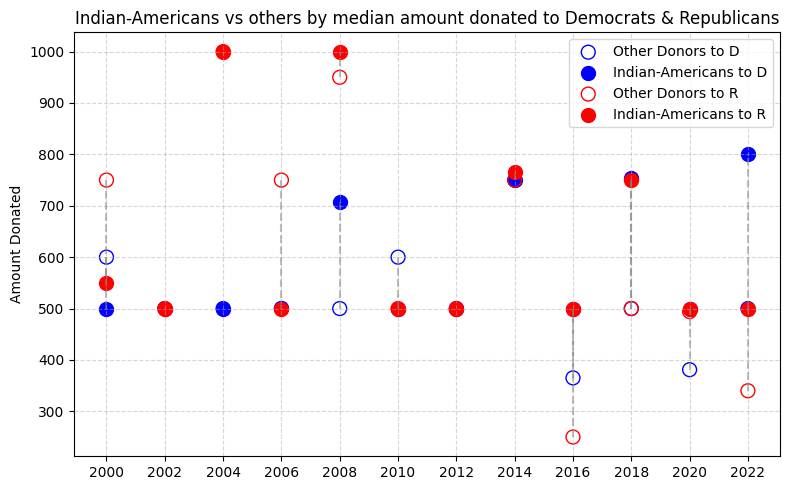

In [13]:
plt.figure(figsize=(8, 5))

cycles = pd.Series(donors_avg["cycle"]).apply(lambda x: str(x)[:4])
for cat, g1, g2 in zip(cycles, donors_avg["median_other_d"], donors_avg["median_indian_d"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)
for cat, g1, g2 in zip(cycles, donors_avg["median_other_r"], donors_avg["median_indian_r"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)

plt.scatter(cycles, donors_avg["median_other_d"], facecolors='none', edgecolors='blue', color='blue', label='Other Donors to D', s=100)
plt.scatter(cycles, donors_avg["median_indian_d"], color='blue', label='Indian-Americans to D', s=100)
plt.scatter(cycles, donors_avg["median_other_r"], facecolors='none', edgecolors='red', label='Other Donors to R', s=100)
plt.scatter(cycles, donors_avg["median_indian_r"], color='red', label='Indian-Americans to R', s=100)

plt.title(f"Indian-Americans vs others by median amount donated to Democrats & Republicans")
plt.ylabel("Amount Donated")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [14]:
sectors_avg = donors[(donors["cycle"] == 2000 + year) & (~donors["sector"].isin(["Ideology/Single Issue", "Unknown", "Party"]))].groupby(['sector', 'indian', 'party']).agg(mean=('total_donated', 'mean'), median=('total_donated', 'median')).reset_index()
sectors_avg = sectors_avg.pivot(index='sector', columns=['indian', 'party'], values=['mean', 'median']).fillna(0).reset_index()
sectors_avg.columns = ['sector',
                      'mean_other_3', 'mean_other_d', 'mean_other_i', 'mean_other_l', 'mean_other_r',
                      'mean_indian_d', 'mean_indian_i', 'mean_indian_r', 'mean_other_u', 'mean_indian_3','mean_indian_l', 
                      'median_other_3', 'median_other_d', 'median_other_i', 'median_other_l', 'median_other_r', 
                      'median_indian_d', 'median_indian_i', 'median_indian_r', 'median_other_u', 'median_indian_3','median_indian_l']
sectors_avg

,sector,mean_other_3,mean_other_d,mean_other_i,mean_other_l,mean_other_r,mean_indian_d,mean_indian_i,mean_indian_r,mean_other_u,...,median_other_d,median_other_i,median_other_l,median_other_r,median_indian_d,median_indian_i,median_indian_r,median_other_u,median_indian_3,median_indian_l
0,Agribusiness,504.000000,895.233524,440.705069,295.000000,1562.224807,1069.336957,386.083333,1627.088235,0.000000,...,300.0,189.0,250.0,500.0,500.0,163.5,507.0,0.0,0.0,0.0
1,Construction,712.080000,855.188859,444.967114,1463.877193,1422.935887,1272.605714,785.068182,1902.725888,273.000000,...,275.0,190.0,250.0,500.0,500.0,248.0,962.0,273.0,0.0,0.0
2,Defense,156.000000,727.385141,550.790161,351.200000,1400.086232,2015.528090,490.117647,706.600000,0.000000,...,299.0,212.0,200.0,500.0,353.0,200.0,500.0,0.0,250.0,0.0
3,Energy,249.777778,1138.275749,515.852604,375.075000,1973.551886,1056.236735,290.720000,1434.027027,1600.000000,...,375.0,201.0,250.0,711.0,500.0,200.0,500.0,1600.0,1037.0,0.0
4,Finance,1102.987342,2033.590235,559.329311,1025.774869,3339.042738,3108.394689,465.566879,2515.987897,0.000000,...,500.0,204.0,300.0,700.0,1000.0,196.0,945.0,0.0,500.0,0.0
5,Health,721.478528,766.619635,484.790265,506.119048,1380.668608,983.035253,608.781553,1756.088142,0.000000,...,250.0,199.0,250.0,474.0,500.0,230.5,594.0,0.0,2800.0,300.0
6,Labor,280.000000,578.930791,425.234192,205.000000,746.890999,633.142857,440.222222,646.200000,0.000000,...,250.0,193.0,150.0,300.0,250.0,217.0,750.0,0.0,0.0,0.0
7,Law,1236.757576,1361.501217,683.581665,626.512500,1457.472372,1396.029104,763.903226,1150.604651,0.000000,...,500.0,275.0,250.0,650.0,666.0,293.0,500.0,0.0,575.0,2875.0
8,Manufacturing,946.625000,1055.437466,418.102118,1383.943396,2732.522432,2086.691489,808.473684,1951.795455,0.000000,...,299.5,189.0,335.0,650.0,750.0,231.0,875.5,0.0,0.0,0.0
9,Tech,618.239130,1503.172706,600.644218,642.918919,1549.178724,1055.353695,732.377171,1151.126246,1288.666667,...,334.0,225.0,250.0,500.0,450.0,262.0,500.0,1000.0,0.0,201.0


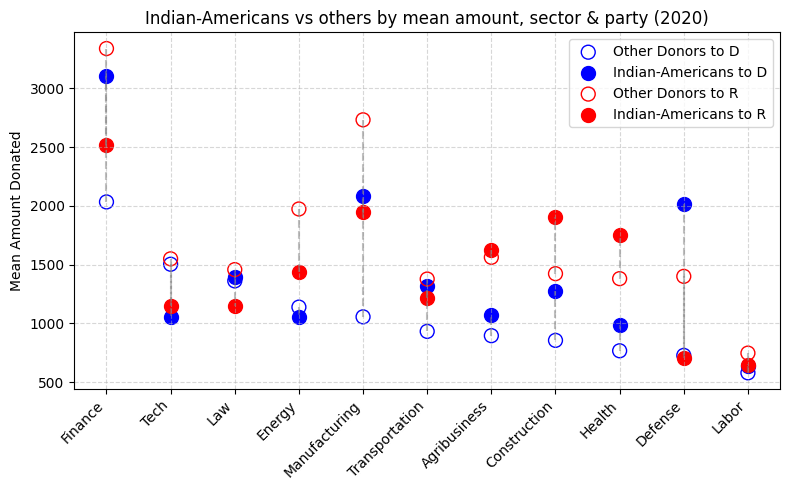

In [15]:
plt.figure(figsize=(8, 5))

sectors_avg = sectors_avg.sort_values(by='mean_other_d', ascending=False)
sectors = sectors_avg["sector"].tolist()

for cat, g1, g2 in zip(sectors, sectors_avg["mean_other_d"], sectors_avg["mean_indian_d"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)
for cat, g1, g2 in zip(sectors, sectors_avg["mean_other_r"], sectors_avg["mean_indian_r"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)

plt.scatter(sectors, sectors_avg["mean_other_d"], facecolors='none', edgecolors='blue', label='Other Donors to D', s=100)
plt.scatter(sectors, sectors_avg["mean_indian_d"], color='blue', label='Indian-Americans to D', s=100)
plt.scatter(sectors, sectors_avg["mean_other_r"], facecolors='none', edgecolors='red', label='Other Donors to R', s=100)
plt.scatter(sectors, sectors_avg["mean_indian_r"], color='red', label='Indian-Americans to R', s=100)

plt.title(f"Indian-Americans vs others by mean amount, sector & party (20{year})")
plt.ylabel("Mean Amount Donated")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

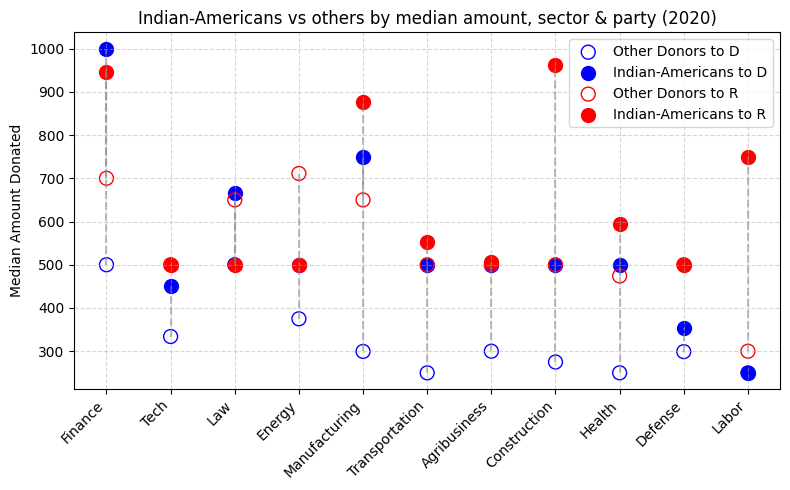

In [16]:
plt.figure(figsize=(8, 5))

for cat, g1, g2 in zip(sectors, sectors_avg["median_other_d"], sectors_avg["median_indian_d"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)
for cat, g1, g2 in zip(sectors, sectors_avg["median_other_r"], sectors_avg["median_indian_r"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)

plt.scatter(sectors, sectors_avg["median_other_d"], facecolors='none', edgecolors='blue', label='Other Donors to D', s=100)
plt.scatter(sectors, sectors_avg["median_indian_d"], color='blue', label='Indian-Americans to D', s=100)
plt.scatter(sectors, sectors_avg["median_other_r"], facecolors='none', edgecolors='red', label='Other Donors to R', s=100)
plt.scatter(sectors, sectors_avg["median_indian_r"], color='red', label='Indian-Americans to R', s=100)

plt.title(f"Indian-Americans vs others by median amount, sector & party (20{year})")
plt.ylabel("Median Amount Donated")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [17]:
# statistical tests

model = ols('total_donated ~ C(indian) + C(sector) + cycle', data=donors).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                 sum_sq          df          F        PR(>F)
C(indian)  6.427925e+09         1.0   0.099848  7.520122e-01
C(sector)  1.172516e+13        13.0  14.010184  6.231110e-32
cycle      4.513125e+11         1.0   7.010446  8.103556e-03
Residual   1.569582e+18  24381042.0        NaN           NaN


In [18]:
tukey = pairwise_tukeyhsd(endog=donors[(donors["total_donated"].notnull())]['total_donated'],
                         groups=donors[(donors["total_donated"].notnull())]['indian'],
                         alpha=0.05)
print(tukey.summary())

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj    lower    upper   reject
-------------------------------------------------------
 False   True  -65.726 0.8615 -803.9104 672.4583  False
-------------------------------------------------------


In [19]:
# donors["dollar_lean"] = donors.apply(lambda x: x["total_donated"] * -1 if x["party"] == "R" else x["total_donated"] * 0 if x["party"] not in ["D", "R"] else x["total_donated"], axis=1)
donors['dollar_lean'] = np.select([donors['party'] == 'R', ~donors['party'].isin(['D', 'R'])], [donors['total_donated'] * -1, 0], default=donors['total_donated'])

donors_lean = donors[~donors["sector"].isin(["Ideology/Single Issue", "Unknown", "Party"])].groupby(['cycle', 'indian', 'sector']).agg(lean=('dem_ratio', 'mean'), dollar_lean=('dollar_lean', 'sum'), total=('total_donated', 'sum')).reset_index()
donors_lean["dollar_lean"] = donors_lean["dollar_lean"] / donors_lean["total"]

donors_lean = donors_lean.pivot(index=['cycle', 'sector'], columns='indian', values=['lean', 'dollar_lean']).fillna(0).reset_index()
donors_lean.columns = ["cycle", 'sector', 'lean_other', 'lean_indian', 'dollar_lean_other', 'dollar_lean_indian']
donors_lean

,cycle,sector,lean_other,lean_indian,dollar_lean_other,dollar_lean_indian
0,2000,Agribusiness,-0.469116,-0.257143,-0.206997,-0.223806
1,2000,Construction,-0.377104,0.123546,-0.192782,0.047022
2,2000,Defense,-0.287838,0.096774,-0.161721,0.142431
3,2000,Energy,-0.508510,0.074177,-0.200370,0.037760
4,2000,Finance,-0.245861,0.129340,-0.091254,0.098863
...,...,...,...,...,...,...
127,2022,Labor,0.518101,0.696970,0.034725,0.118182
128,2022,Law,0.380793,0.621227,0.214890,0.334286
129,2022,Manufacturing,-0.291933,0.573621,-0.086896,0.445630
130,2022,Tech,0.536249,0.681900,0.191621,0.395733


In [20]:
donors_pac_lean = donors[~donors["sector"].isin(["Ideology/Single Issue", "Unknown", "Party"])].groupby(['cycle', 'indian', 'sector', 'level']).agg(lean=('dem_ratio', 'mean'), dollar_lean=('dollar_lean', 'sum'), total=('total_donated', 'sum')).reset_index()
donors_pac_lean["dollar_lean"] = donors_pac_lean["dollar_lean"] / donors_pac_lean["total"]

donors_pac_lean = donors_pac_lean.pivot(index=['cycle', 'sector', 'level'], columns='indian', values=['lean', 'dollar_lean']).fillna(0).reset_index()
donors_pac_lean.columns = ["cycle", 'sector', 'level', 'lean_other', 'lean_indian', 'dollar_lean_other', 'dollar_lean_indian']
donors_pac_lean

,cycle,sector,level,lean_other,lean_indian,dollar_lean_other,dollar_lean_indian
0,2000,Agribusiness,House,-0.410636,-0.180952,-0.391971,-0.178392
1,2000,Agribusiness,PAC,-0.517375,0.111111,0.000000,0.000000
2,2000,Agribusiness,President,-0.642367,-0.714286,-0.674355,-0.904762
3,2000,Construction,House,-0.328470,0.126309,-0.308521,0.120287
4,2000,Construction,PAC,-0.471285,0.321268,0.000000,0.000000
...,...,...,...,...,...,...,...
484,2022,Tech,Unknown,0.222222,0.000000,0.000000,0.000000
485,2022,Transportation,House,-0.172232,0.275952,-0.284706,0.420554
486,2022,Transportation,PAC,-0.632181,-0.219719,-0.086110,-0.055213
487,2022,Transportation,President,0.738240,0.800000,0.001602,0.310067


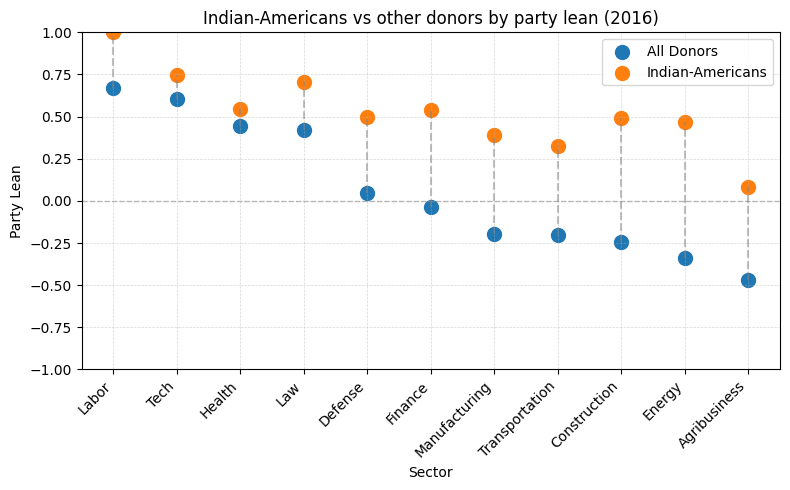

In [ ]:
donors_lean_year = donors_lean[donors_lean["cycle"] == 2000 + 16].sort_values(by="lean_other", ascending=False)
sectors = donors_lean_year["sector"]

plt.figure(figsize=(8, 5))

for cat, g1, g2 in zip(sectors, donors_lean_year["lean_other"], donors_lean_year["lean_indian"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)

plt.scatter(sectors, donors_lean_year["lean_other"], cmap="coolwarm_r", label='Other Donors', s=100)
plt.scatter(sectors, donors_lean_year["lean_indian"], cmap="coolwarm_r", label='Indian-Americans', s=100)

plt.title(f"Indian-Americans vs other donors by party lean (20{16})")
plt.xlabel("Sector")
plt.ylabel("Party Lean")
plt.xticks(rotation=45, ha='right')
plt.ylim(-1, 1)

plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.axhline(y=0, color='grey', alpha=0.5, linewidth=1, linestyle='--')

plt.tight_layout()
plt.show()

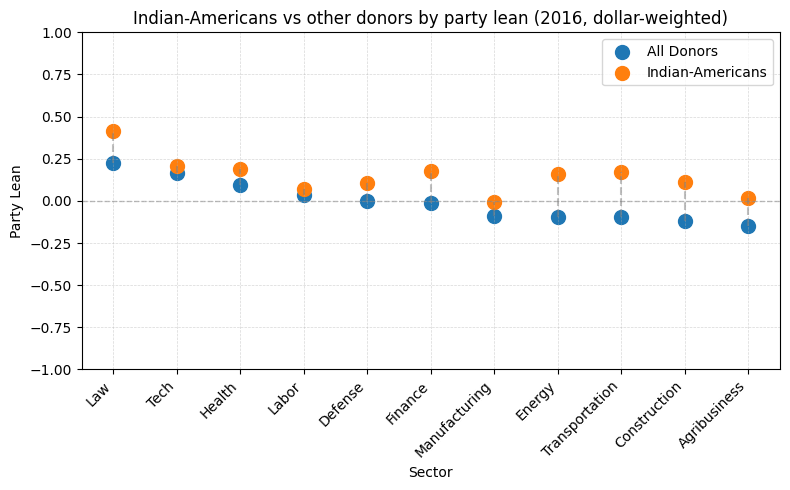

In [ ]:
donors_lean_year = donors_lean[donors_lean["cycle"] == 2000 + 16].sort_values(by="dollar_lean_other", ascending=False)
sectors = donors_lean_year["sector"]

plt.figure(figsize=(8, 5))

for cat, g1, g2 in zip(sectors, donors_lean_year["dollar_lean_other"], donors_lean_year["dollar_lean_indian"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)

plt.scatter(sectors, donors_lean_year["dollar_lean_other"], cmap="coolwarm_r", label='Other Donors', s=100)
plt.scatter(sectors, donors_lean_year["dollar_lean_indian"], cmap="coolwarm_r", label='Indian-Americans', s=100)

plt.title(f"Indian-Americans vs other donors by party lean (20{16}, dollar-weighted)")
plt.xlabel("Sector")
plt.ylabel("Party Lean")
plt.xticks(rotation=45, ha='right')
plt.ylim(-1, 1)

plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.axhline(y=0, color='grey', alpha=0.5, linewidth=1, linestyle='--')

plt.tight_layout()
plt.show()

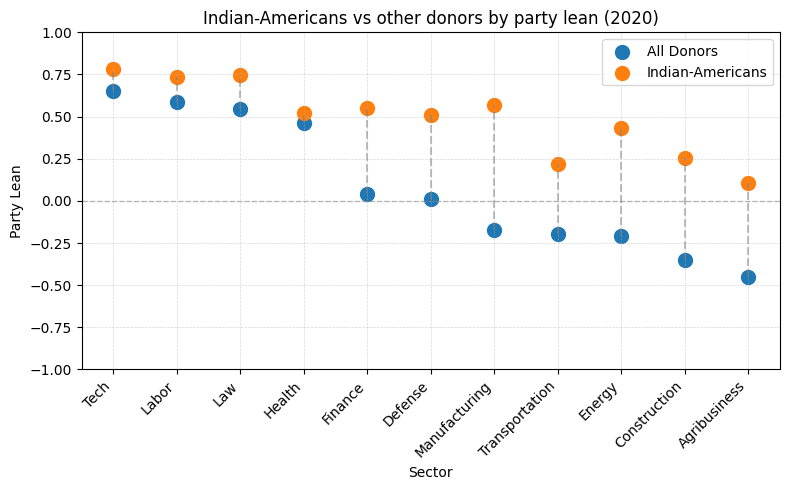

In [ ]:
donors_lean_year = donors_lean[donors_lean["cycle"] == 2000 + year].sort_values(by="lean_other", ascending=False)
sectors = donors_lean_year["sector"]

plt.figure(figsize=(8, 5))

for cat, g1, g2 in zip(sectors, donors_lean_year["lean_other"], donors_lean_year["lean_indian"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)

plt.scatter(sectors, donors_lean_year["lean_other"], cmap="coolwarm_r", label='Other Donors', s=100)
plt.scatter(sectors, donors_lean_year["lean_indian"], cmap="coolwarm_r", label='Indian-Americans', s=100)

plt.title(f"Indian-Americans vs other donors by party lean (20{year})")
plt.xlabel("Sector")
plt.ylabel("Party Lean")
plt.xticks(rotation=45, ha='right')
plt.ylim(-1, 1)

plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.axhline(y=0, color='grey', alpha=0.5, linewidth=1, linestyle='--')

plt.tight_layout()
plt.show()

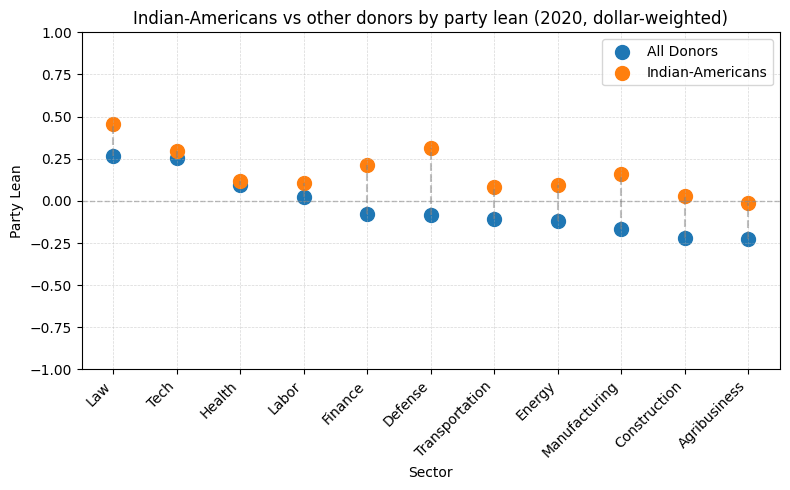

In [ ]:
donors_lean_year = donors_lean[donors_lean["cycle"] == 2000 + year].sort_values(by="dollar_lean_other", ascending=False)
sectors = donors_lean_year["sector"]

plt.figure(figsize=(8, 5))

for cat, g1, g2 in zip(sectors, donors_lean_year["dollar_lean_other"], donors_lean_year["dollar_lean_indian"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)

plt.scatter(sectors, donors_lean_year["dollar_lean_other"], cmap="coolwarm_r", label='Other Donors', s=100)
plt.scatter(sectors, donors_lean_year["dollar_lean_indian"], cmap="coolwarm_r", label='Indian-Americans', s=100)

plt.title(f"Indian-Americans vs other donors by party lean (20{year}, dollar-weighted)")
plt.xlabel("Sector")
plt.ylabel("Party Lean")
plt.xticks(rotation=45, ha='right')
plt.ylim(-1, 1)

plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.axhline(y=0, color='grey', alpha=0.5, linewidth=1, linestyle='--')

plt.tight_layout()
plt.show()

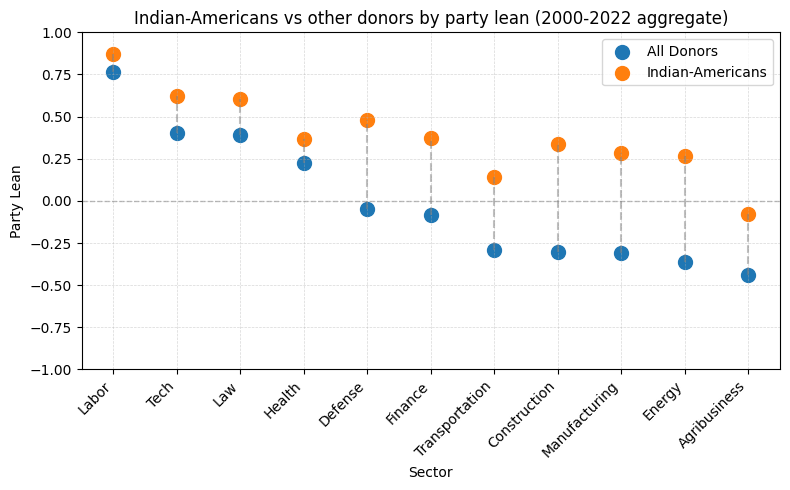

In [ ]:
donors_lean_year = donors_lean.groupby(['sector']).agg(lean_other=('lean_other', 'mean'), lean_indian=('lean_indian', 'mean')).reset_index().sort_values(by="lean_other", ascending=False)
sectors = donors_lean_year["sector"]

plt.figure(figsize=(8, 5))

for cat, g1, g2 in zip(sectors, donors_lean_year["lean_other"], donors_lean_year["lean_indian"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)

plt.scatter(sectors, donors_lean_year["lean_other"], cmap="coolwarm_r", label='Other Donors', s=100)
plt.scatter(sectors, donors_lean_year["lean_indian"], cmap="coolwarm_r", label='Indian-Americans', s=100)

plt.title(f"Indian-Americans vs other donors by party lean (2000-2022 aggregate)")
plt.xlabel("Sector")
plt.ylabel("Party Lean")
plt.xticks(rotation=45, ha='right')
plt.ylim(-1, 1)

plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.axhline(y=0, color='grey', alpha=0.5, linewidth=1, linestyle='--')

plt.tight_layout()
plt.show()

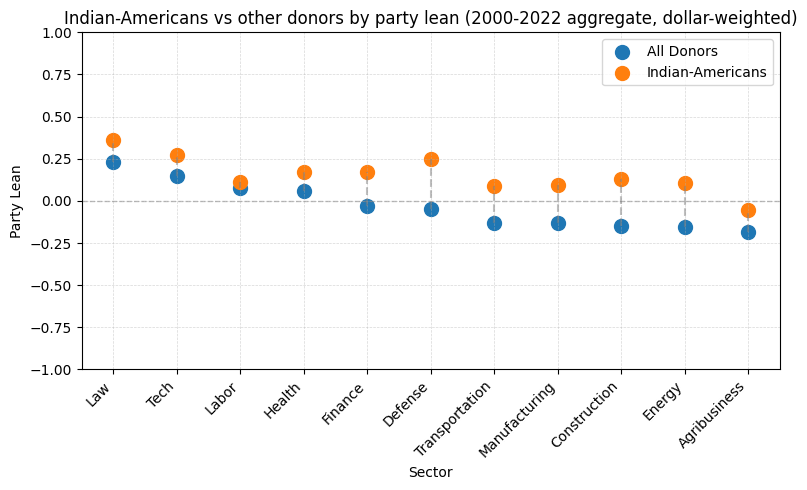

In [ ]:
donors_lean_year = donors_lean.groupby(['sector']).agg(lean_other=('lean_other', 'mean'), lean_indian=('lean_indian', 'mean'), dollar_lean_other=('dollar_lean_other', 'mean'), dollar_lean_indian=('dollar_lean_indian', 'mean')).reset_index().sort_values(by="dollar_lean_other", ascending=False)
sectors = donors_lean_year["sector"]

plt.figure(figsize=(8, 5))

for cat, g1, g2 in zip(sectors, donors_lean_year["dollar_lean_other"], donors_lean_year["dollar_lean_indian"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)

plt.scatter(sectors, donors_lean_year["dollar_lean_other"], cmap="coolwarm_r", label='Other Donors', s=100)
plt.scatter(sectors, donors_lean_year["dollar_lean_indian"], cmap="coolwarm_r", label='Indian-Americans', s=100)

plt.title(f"Indian-Americans vs other donors by party lean (2000-2022 aggregate, dollar-weighted)")
plt.xlabel("Sector")
plt.ylabel("Party Lean")
plt.xticks(rotation=45, ha='right')
plt.ylim(-1, 1)

plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.axhline(y=0, color='grey', alpha=0.5, linewidth=1, linestyle='--')

plt.tight_layout()
plt.show()

In [27]:
# statistical tests

model = ols('dem_ratio ~ C(indian) + C(sector) + cycle', data=donors).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                 sum_sq          df             F  PR(>F)
C(indian)  2.564654e+04         1.0  29044.732310     0.0
C(sector)  1.046153e+06        13.0  91136.084083     0.0
cycle      2.693787e+04         1.0  30507.160466     0.0
Residual   1.566562e+07  17741327.0           NaN     NaN


In [28]:
tukey = pairwise_tukeyhsd(endog=donors[(donors["dem_ratio"].notnull())]['dem_ratio'],
                         groups=donors[(donors["dem_ratio"].notnull())]['indian'],
                         alpha=0.05)
print(tukey.summary())

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower  upper  reject
-------------------------------------------------
 False   True   0.3738   0.0 0.3701 0.3776   True
-------------------------------------------------


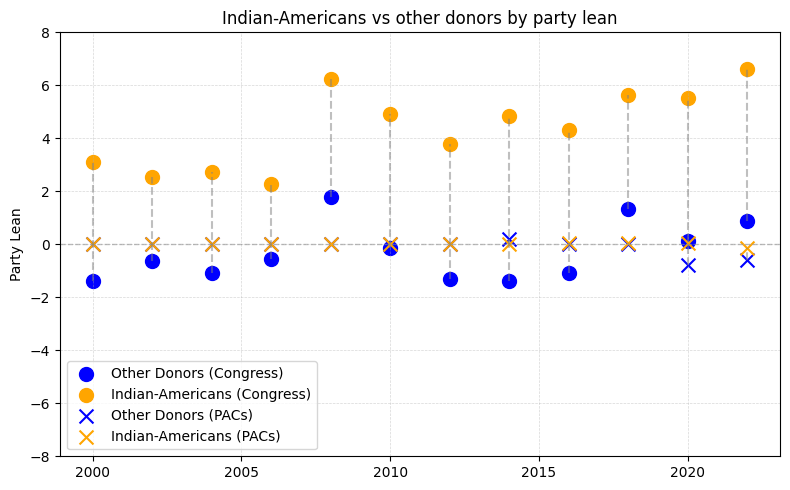

In [57]:
# this needs to be fixed by aggregating cycle averages correctly (currently sums party leans of each sector instead of calculating dollar weighted lean)
# also, the "regular" party lean needs to be fixed because it's at the level of donations, not donors

donors_lean_yearly = donors_pac_lean.groupby(["cycle", "level"]).sum().sort_values(by="cycle", ascending=True).reset_index()
cycles = donors_lean_yearly[donors_lean_yearly["level"] == "President"]["cycle"]

plt.figure(figsize=(8, 5))

for cat, g1, g2 in zip(cycles, donors_lean_yearly[donors_lean_yearly["level"] == "House"]["dollar_lean_other"], donors_lean_yearly[donors_lean_yearly["level"] == "House"]["dollar_lean_indian"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)
for cat, g1, g2 in zip(cycles, donors_lean_yearly[donors_lean_yearly["level"] == "PAC"]["dollar_lean_other"], donors_lean_yearly[donors_lean_yearly["level"] == "PAC"]["dollar_lean_indian"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)

plt.scatter(cycles, donors_lean_yearly[donors_lean_yearly["level"] == "House"]["dollar_lean_other"], color="blue", label='Other Donors (Congress)', s=100)
plt.scatter(cycles, donors_lean_yearly[donors_lean_yearly["level"] == "House"]["dollar_lean_indian"], color="orange",  label='Indian-Americans (Congress)', s=100)
plt.scatter(cycles, donors_lean_yearly[donors_lean_yearly["level"] == "PAC"]["dollar_lean_other"], marker="x", color="blue", label='Other Donors (PACs)', s=100)
plt.scatter(cycles, donors_lean_yearly[donors_lean_yearly["level"] == "PAC"]["dollar_lean_indian"], marker="x", color="orange",  label='Indian-Americans (PACs)', s=100)

plt.title(f"Indian-Americans vs other donors by party lean")
plt.ylabel("Party Lean")
plt.ylim(-8, 8)

plt.legend(loc='lower left')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.axhline(y=0, color='grey', alpha=0.5, linewidth=1, linestyle='--')

plt.tight_layout()
plt.show()

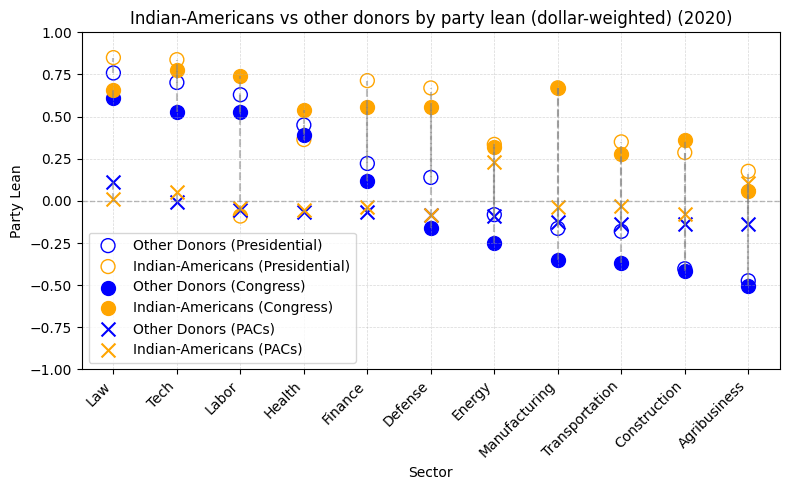

In [41]:
donors_lean_year = donors_pac_lean[donors_pac_lean["cycle"] == 2000 + year].sort_values(by="dollar_lean_other", ascending=False)
sectors = donors_lean_year[donors_lean_year["level"] == "President"]["sector"]

plt.figure(figsize=(8, 5))

for cat, g1, g2 in zip(sectors, donors_lean_year[donors_lean_year["level"] == "President"]["dollar_lean_other"], donors_lean_year[donors_lean_year["level"] == "President"]["dollar_lean_indian"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)
for cat, g1, g2 in zip(sectors, donors_lean_year[donors_lean_year["level"] == "House"]["dollar_lean_other"], donors_lean_year[donors_lean_year["level"] == "House"]["dollar_lean_indian"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)
for cat, g1, g2 in zip(sectors, donors_lean_year[donors_lean_year["level"] == "PAC"]["dollar_lean_other"], donors_lean_year[donors_lean_year["level"] == "PAC"]["dollar_lean_indian"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)

plt.scatter(sectors, donors_lean_year[donors_lean_year["level"] == "President"]["dollar_lean_other"], facecolors='none', edgecolors='blue', label='Other Donors (Presidential)', s=100)
plt.scatter(sectors, donors_lean_year[donors_lean_year["level"] == "President"]["dollar_lean_indian"], facecolors='none', edgecolors='orange', label='Indian-Americans (Presidential)', s=100)
plt.scatter(sectors, donors_lean_year[donors_lean_year["level"] == "House"]["dollar_lean_other"], color="blue", label='Other Donors (Congress)', s=100)
plt.scatter(sectors, donors_lean_year[donors_lean_year["level"] == "House"]["dollar_lean_indian"], color="orange",  label='Indian-Americans (Congress)', s=100)
plt.scatter(sectors, donors_lean_year[donors_lean_year["level"] == "PAC"]["dollar_lean_other"], marker="x", color="blue", label='Other Donors (PACs)', s=100)
plt.scatter(sectors, donors_lean_year[donors_lean_year["level"] == "PAC"]["dollar_lean_indian"], marker="x", color="orange",  label='Indian-Americans (PACs)', s=100)

plt.title(f"Indian-Americans vs other donors by party lean (dollar-weighted) (20{year})")
plt.xlabel("Sector")
plt.ylabel("Party Lean")
plt.xticks(rotation=45, ha='right')
plt.ylim(-1, 1)

plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.axhline(y=0, color='grey', alpha=0.5, linewidth=1, linestyle='--')

plt.tight_layout()
plt.show()

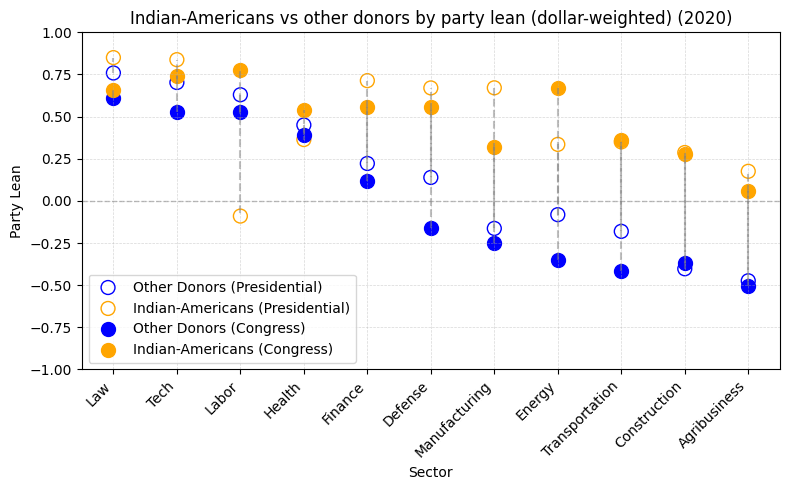

In [42]:
donors_lean_year = donors_pac_lean[donors_pac_lean["cycle"] == 2000 + year].sort_values(by="lean_other", ascending=False)
sectors = donors_lean_year[donors_lean_year["level"] == "President"]["sector"]

plt.figure(figsize=(8, 5))

for cat, g1, g2 in zip(sectors, donors_lean_year[donors_lean_year["level"] == "President"]["dollar_lean_other"], donors_lean_year[donors_lean_year["level"] == "President"]["dollar_lean_indian"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)
for cat, g1, g2 in zip(sectors, donors_lean_year[donors_lean_year["level"] == "House"]["dollar_lean_other"], donors_lean_year[donors_lean_year["level"] == "House"]["dollar_lean_indian"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)

plt.scatter(sectors, donors_lean_year[donors_lean_year["level"] == "President"]["dollar_lean_other"], facecolors='none', edgecolors='blue', label='Other Donors (Presidential)', s=100)
plt.scatter(sectors, donors_lean_year[donors_lean_year["level"] == "President"]["dollar_lean_indian"], facecolors='none', edgecolors='orange', label='Indian-Americans (Presidential)', s=100)
plt.scatter(sectors, donors_lean_year[donors_lean_year["level"] == "House"]["dollar_lean_other"], color="blue", label='Other Donors (Congress)', s=100)
plt.scatter(sectors, donors_lean_year[donors_lean_year["level"] == "House"]["dollar_lean_indian"], color="orange",  label='Indian-Americans (Congress)', s=100)

plt.title(f"Indian-Americans vs other donors by party lean (dollar-weighted) (20{year})")
plt.xlabel("Sector")
plt.ylabel("Party Lean")
plt.xticks(rotation=45, ha='right')
plt.ylim(-1, 1)

plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.axhline(y=0, color='grey', alpha=0.5, linewidth=1, linestyle='--')

plt.tight_layout()
plt.show()

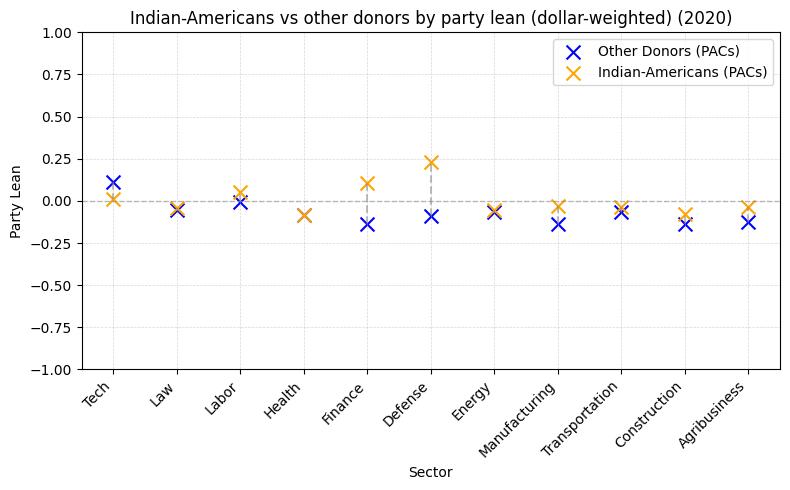

In [43]:
donors_lean_year = donors_pac_lean[donors_pac_lean["cycle"] == 2000 + year].sort_values(by="lean_other", ascending=False)
sectors = donors_lean_year[donors_lean_year["level"] == "PAC"]["sector"]

plt.figure(figsize=(8, 5))

for cat, g1, g2 in zip(sectors, donors_lean_year[donors_lean_year["level"] == "PAC"]["dollar_lean_other"], donors_lean_year[donors_lean_year["level"] == "PAC"]["dollar_lean_indian"]):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)

plt.scatter(sectors, donors_lean_year[donors_lean_year["level"] == "PAC"]["dollar_lean_other"], marker="x", color="blue", label='Other Donors (PACs)', s=100)
plt.scatter(sectors, donors_lean_year[donors_lean_year["level"] == "PAC"]["dollar_lean_indian"], marker="x", color="orange",  label='Indian-Americans (PACs)', s=100)

plt.title(f"Indian-Americans vs other donors by party lean (dollar-weighted) (20{year})")
plt.xlabel("Sector")
plt.ylabel("Party Lean")
plt.xticks(rotation=45, ha='right')
plt.ylim(-1, 1)

plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.axhline(y=0, color='grey', alpha=0.5, linewidth=1, linestyle='--')

plt.tight_layout()
plt.show()

In [37]:
print("Overall, presidential: ", donors_pac_lean[(donors_pac_lean["cycle"] == 2000 + year) & (donors_pac_lean["level"] == "President")]["dollar_lean_other"].mean())
print("Indians, presidential: ", donors_pac_lean[(donors_pac_lean["cycle"] == 2000 + year) & (donors_pac_lean["level"] == "President")]["dollar_lean_indian"].mean())
print("Overall, congressional: ", donors_pac_lean[(donors_pac_lean["cycle"] == 2000 + year) & (donors_pac_lean["level"] == "House")]["dollar_lean_other"].mean())
print("Indians, congressional: ", donors_pac_lean[(donors_pac_lean["cycle"] == 2000 + year) & (donors_pac_lean["level"] == "House")]["dollar_lean_indian"].mean())
print("Overall, PAC: ", donors_pac_lean[(donors_pac_lean["cycle"] == 2000 + year) & (donors_pac_lean["level"] == "PAC")]["dollar_lean_other"].mean())
print("Indians, PAC: ", donors_pac_lean[(donors_pac_lean["cycle"] == 2000 + year) & (donors_pac_lean["level"] == "PAC")]["dollar_lean_indian"].mean())

Overall, presidential:  0.1455451639604563
Indians, presidential:  0.469533863032137
Overall, congressional:  0.010594387938757978
Indians, congressional:  0.5018695108347638
Overall, PAC:  -0.07180083953653019
Indians, PAC:  0.00415028629431664


In [45]:
sectors_count = donors[~donors["sector"].isin(["Ideology/Single Issue", "Unknown", "Party"])].groupby(['cycle', 'sector', 'indian', 'party']).agg(sum=('total_donated', 'sum'), count=('contrib_id', 'count')).reset_index()
sectors_count_pivot = sectors_count.pivot(index=['cycle', 'sector'], columns=['indian', 'party'], values=['sum', 'count']).fillna(0).reset_index()
sectors_count_pivot.columns = ['cycle', 'sector',
                      'sum_other_3', 'sum_other_d', 'sum_other_i', 'sum_other_l', 'sum_other_r',
                      'sum_indian_d', 'sum_indian_r', 'sum_indian_3', 'sum_other_u', 'sum_indian_l','sum_indian_i', 'sum_indian_u', 
                      'count_other_3', 'count_other_d', 'count_other_i', 'count_other_l', 'count_other_r', 
                      'count_indian_d', 'count_indian_r', 'count_indian_3', 'count_other_u', 'count_indian_l','count_indian_i', 'count_indian_u']
sectors_count_pivot[['cycle', 'sector', 'sum_other_d', 'sum_indian_d', 'sum_other_r', 'sum_indian_r', 'count_other_d', 'count_indian_d', 'count_other_r', 'count_indian_r']]

,cycle,sector,sum_other_d,sum_indian_d,sum_other_r,sum_indian_r,count_other_d,count_indian_d,count_other_r,count_indian_r
0,2000,Agribusiness,3398157.0,17100.0,9380760.0,38450.0,4536.0,24.0,12235.0,45.0
1,2000,Construction,9558329.0,140641.0,20287405.0,119601.0,10728.0,158.0,22881.0,130.0
2,2000,Defense,967617.0,14166.0,1701795.0,9200.0,1216.0,15.0,2184.0,13.0
3,2000,Energy,3531673.0,52550.0,10750955.0,46050.0,4261.0,56.0,12359.0,48.0
4,2000,Finance,45497965.0,345102.0,71193063.0,232801.0,48164.0,392.0,78189.0,297.0
...,...,...,...,...,...,...,...,...,...,...
127,2022,Labor,2672786.0,28787.0,497269.0,2500.0,3152.0,18.0,902.0,4.0
128,2022,Law,132130108.0,1247259.0,59223286.0,252462.0,71435.0,586.0,33144.0,135.0
129,2022,Manufacturing,10295884.0,1183705.0,27065891.0,105037.0,5808.0,255.0,9396.0,64.0
130,2022,Tech,110535326.0,2451784.0,33165545.0,365919.0,48104.0,1189.0,13649.0,227.0


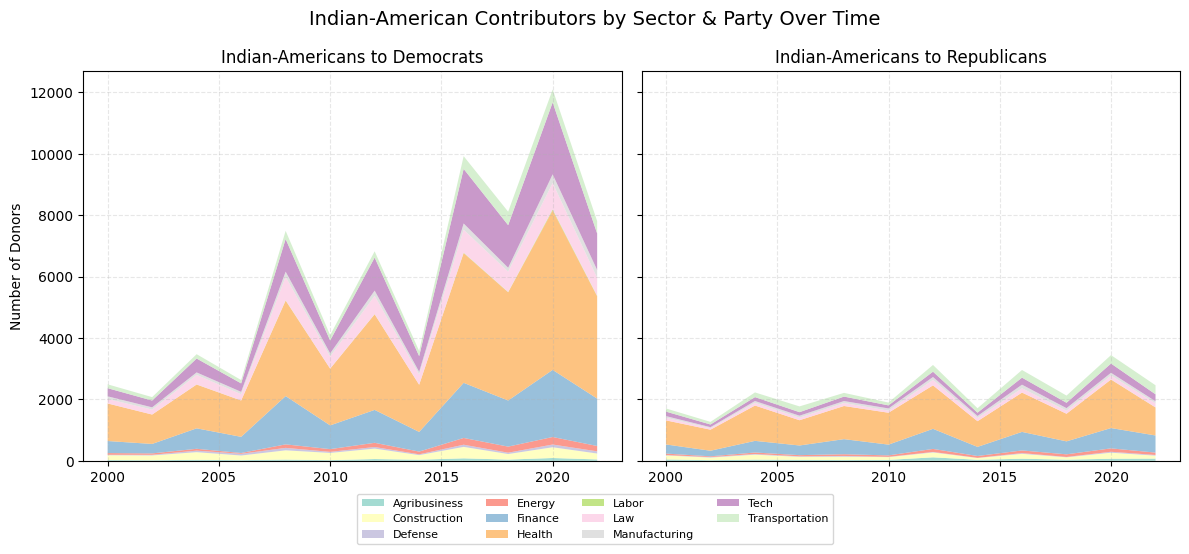

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

sectors = sectors_count_pivot["sector"].unique()
colors = sns.color_palette("Set3", n_colors=len(sectors))

count_indian_d = sectors_count_pivot.pivot(index='cycle', columns='sector', values='count_indian_d')
count_indian_r = sectors_count_pivot.pivot(index='cycle', columns='sector', values='count_indian_r')

ax1.stackplot(
    count_indian_d.index,
    count_indian_d.T,
    labels=sectors,
    colors=colors,
    alpha=0.8,
)
ax1.set_title("Indian-Americans to Democrats", fontsize=12)
ax1.set_ylabel("Number of Donors")
ax1.grid(True, linestyle='--', alpha=0.3)

ax2.stackplot(
    count_indian_r.index,
    count_indian_r.T,
    labels=sectors,
    colors=colors,
    alpha=0.8,
)
ax2.set_title("Indian-Americans to Republicans", fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.3)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=4,
    fontsize=8
)

plt.suptitle("Indian-American Contributors by Sector & Party Over Time", fontsize=14)
plt.tight_layout()
plt.show()

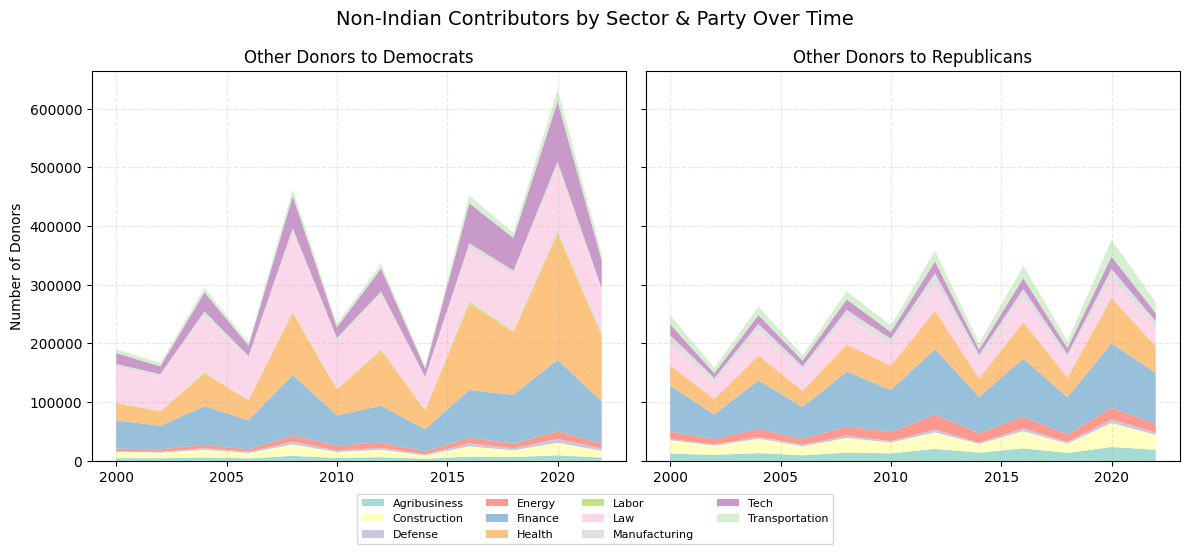

In [48]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

count_other_d = sectors_count_pivot.pivot(index='cycle', columns='sector', values='count_other_d')
count_other_r = sectors_count_pivot.pivot(index='cycle', columns='sector', values='count_other_r')

ax1.stackplot(
    count_other_d.index,
    count_other_d.T,
    labels=sectors,
    colors=colors,
    alpha=0.8,
)
ax1.set_title("Other Donors to Democrats", fontsize=12)
ax1.set_ylabel("Number of Donors")
ax1.grid(True, linestyle='--', alpha=0.3)

ax2.stackplot(
    count_other_r.index,
    count_other_r.T,
    labels=sectors,
    colors=colors,
    alpha=0.8,
)
ax2.set_title("Other Donors to Republicans", fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.3)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=4,
    fontsize=8
)

plt.suptitle("Non-Indian Contributors by Sector & Party Over Time", fontsize=14)
plt.tight_layout()
plt.show()

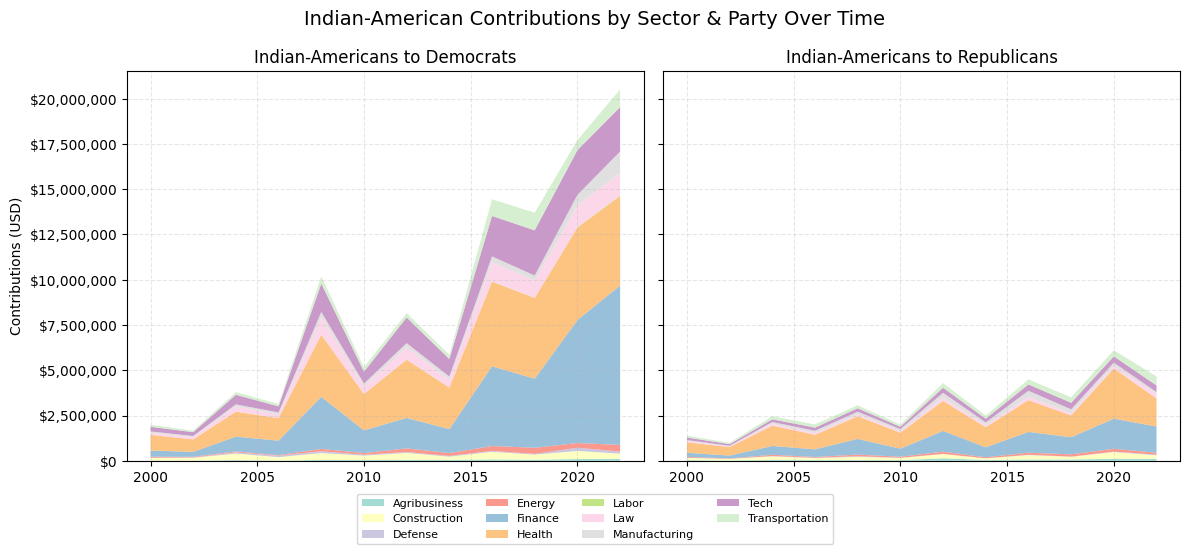

In [51]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

sum_indian_d = sectors_count_pivot.pivot(index='cycle', columns='sector', values='sum_indian_d')
sum_indian_r = sectors_count_pivot.pivot(index='cycle', columns='sector', values='sum_indian_r')

ax1.stackplot(
    sum_indian_d.index,
    sum_indian_d.T,
    labels=sectors,
    colors=colors,
    alpha=0.8,
)
ax1.set_title("Indian-Americans to Democrats", fontsize=12)
ax1.set_ylabel("Contributions (USD)")
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))
ax1.grid(True, linestyle='--', alpha=0.3)

ax2.stackplot(
    sum_indian_r.index,
    sum_indian_r.T,
    labels=sectors,
    colors=colors,
    alpha=0.8,
)
ax2.set_title("Indian-Americans to Republicans", fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.3)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=4,
    fontsize=8
)

plt.suptitle("Indian-American Contributions by Sector & Party Over Time", fontsize=14)
plt.tight_layout()
plt.show()

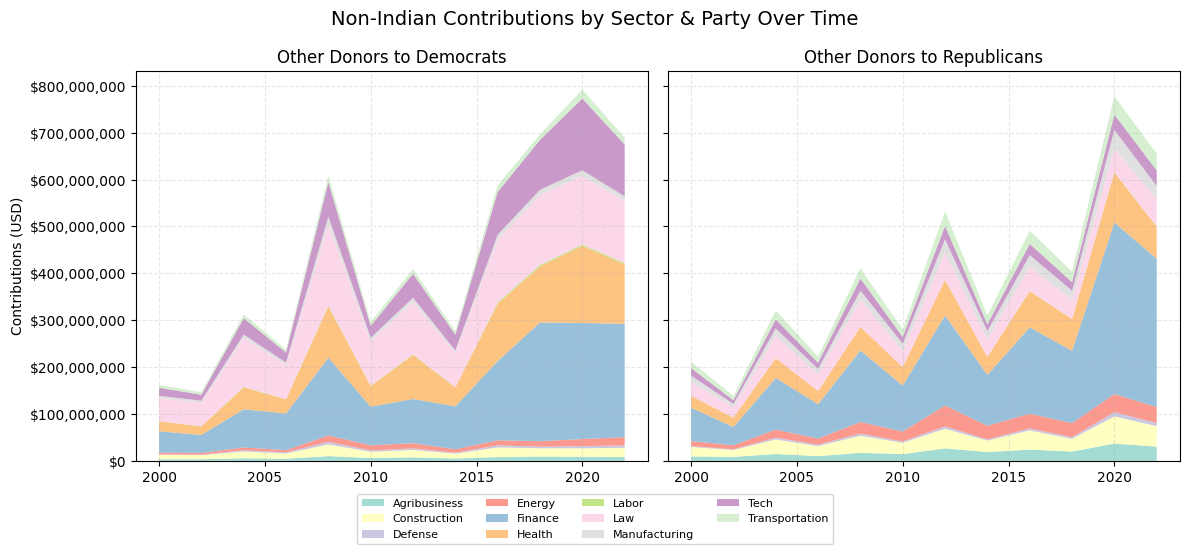

In [53]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

sum_other_d = sectors_count_pivot.pivot(index='cycle', columns='sector', values='sum_other_d')
sum_other_r = sectors_count_pivot.pivot(index='cycle', columns='sector', values='sum_other_r')

ax1.stackplot(
    sum_other_d.index,
    sum_other_d.T,
    labels=sectors,
    colors=colors,
    alpha=0.8,
)
ax1.set_title("Other Donors to Democrats", fontsize=12)
ax1.set_ylabel("Contributions (USD)")
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))
ax1.grid(True, linestyle='--', alpha=0.3)

ax2.stackplot(
    sum_other_r.index,
    sum_other_r.T,
    labels=sectors,
    colors=colors,
    alpha=0.8,
)
ax2.set_title("Other Donors to Republicans", fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.3)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=4,
    fontsize=8
)

plt.suptitle("Non-Indian Contributions by Sector & Party Over Time", fontsize=14)
plt.tight_layout()
plt.show()

In [59]:
key_states = ['CA', 'TX', 'IL', 'NY', 'NJ', 'FL', 'VA', 'MA', 'WA']

states_count = donors.groupby(['cycle', 'state', 'indian', 'party']).agg(sum=('total_donated', 'sum'), count=('contrib_id', 'count')).reset_index()
states_count_pivot = states_count.pivot(index=['cycle', 'state'], columns=['indian', 'party'], values=['sum', 'count']).fillna(0).reset_index()
states_count_pivot.columns = ['cycle', 'state',
                      'sum_other_3', 'sum_other_d', 'sum_other_i', 'sum_other_l', 'sum_other_r',
                      'sum_indian_d', 'sum_indian_r', 'sum_other_u', 'sum_indian_3', 'sum_indian_l','sum_indian_i', 'sum_indian_u', 
                      'count_other_3', 'count_other_d', 'count_other_i', 'count_other_l', 'count_other_r', 
                      'count_indian_d', 'count_indian_r', 'count_other_u', 'count_indian_3', 'count_indian_l','count_indian_i', 'count_indian_u']

states_count_pivot['state'] = states_count_pivot['state'].where(states_count_pivot['state'].isin(key_states), 'Others')
states_count_pivot = states_count_pivot.groupby(['cycle', 'state']
).agg({
    'sum_other_d': 'sum',
    'sum_indian_d': 'sum',
    'sum_other_r': 'sum',
    'sum_indian_r': 'sum',
    'count_other_d': 'sum',
    'count_indian_d': 'sum',
    'count_other_r': 'sum',
    'count_indian_r': 'sum'
}).reset_index()

states_count_pivot

,cycle,state,sum_other_d,sum_indian_d,sum_other_r,sum_indian_r,count_other_d,count_indian_d,count_other_r,count_indian_r
0,2000,CA,33503164.0,537949.0,34367810.0,325636.0,40415.0,644.0,42626.0,437.0
1,2000,FL,13590428.0,168031.0,22222672.0,250704.0,16573.0,208.0,27279.0,297.0
2,2000,IL,12321485.0,171692.0,12449754.0,80000.0,15008.0,218.0,15828.0,104.0
3,2000,MA,11609622.0,69400.0,5021970.0,14650.0,15035.0,95.0,6364.0,16.0
4,2000,NJ,17752936.0,383178.0,19277003.0,165736.0,19948.0,501.0,22178.0,188.0
...,...,...,...,...,...,...,...,...,...,...
115,2022,NY,284046065.0,5753212.0,119927527.0,946223.0,148710.0,2424.0,69908.0,650.0
116,2022,Others,978699457.0,10812742.0,996547216.0,5222333.0,717742.0,7686.0,909124.0,4207.0
117,2022,TX,78308399.0,2082196.0,210283812.0,1307680.0,60357.0,1238.0,174498.0,901.0
118,2022,VA,58801288.0,1578054.0,205373713.0,298067.0,51735.0,959.0,60945.0,247.0


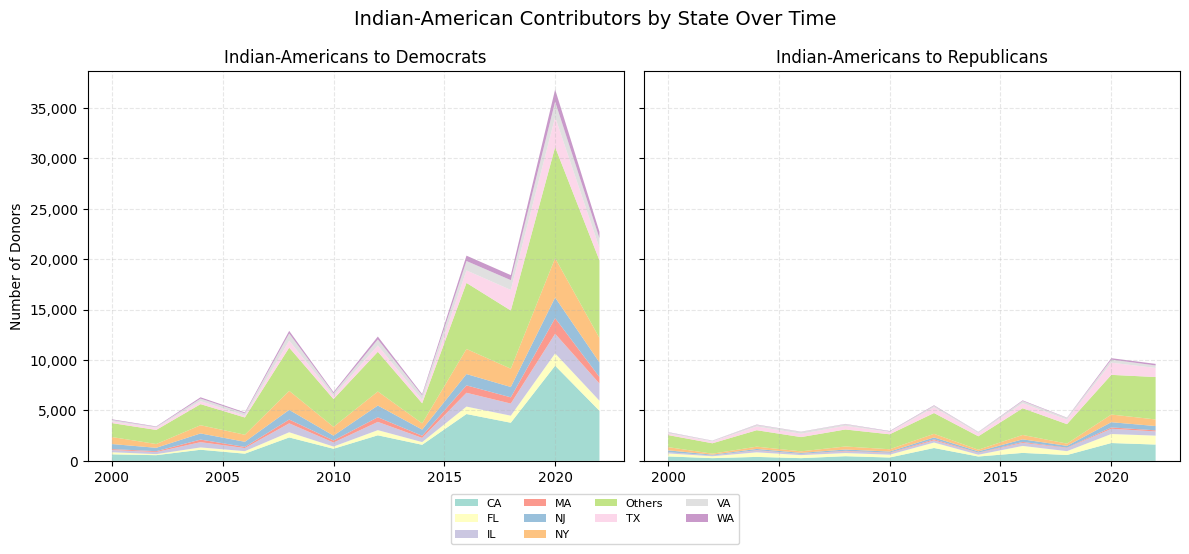

In [62]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

state_names = states_count_pivot["state"].unique()
colors = sns.color_palette("Set3", n_colors=len(state_names))

count_indian_d = states_count_pivot.pivot(index='cycle', columns='state', values='count_indian_d')
# sum_indian_d = sum_indian_d.div(sum_indian_d.sum(axis=1), axis=0) * 100
count_indian_r = states_count_pivot.pivot(index='cycle', columns='state', values='count_indian_r')
# sum_indian_r = sum_indian_r.div(sum_indian_r.sum(axis=1), axis=0) * 100

ax1.stackplot(
    count_indian_d.index,
    count_indian_d.T,
    labels=state_names,
    colors=colors,
    alpha=0.8,
)
ax1.set_title("Indian-Americans to Democrats", fontsize=12)
ax1.set_ylabel("Number of Donors")
# ax1.set_ylim(0, 100)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}'))
ax1.grid(True, linestyle='--', alpha=0.3)

ax2.stackplot(
    count_indian_r.index,
    count_indian_r.T,
    labels=state_names,
    colors=colors,
    alpha=0.8,
)
ax2.set_title("Indian-Americans to Republicans", fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.3)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=4,
    fontsize=8
)

plt.suptitle("Indian-American Contributors by State Over Time", fontsize=14)
plt.tight_layout()
plt.show()

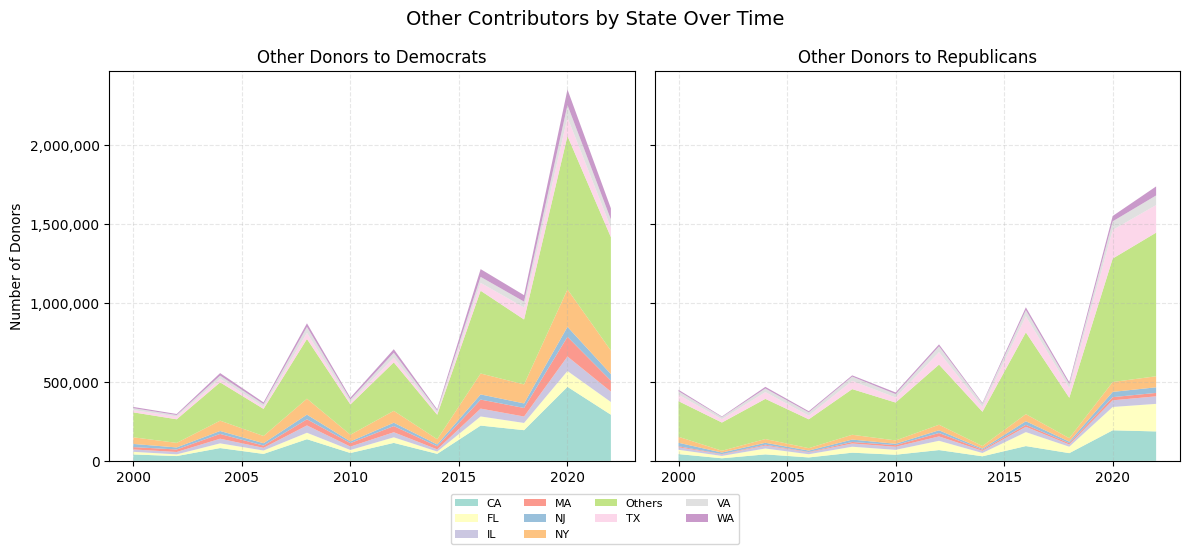

In [63]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

count_other_d = states_count_pivot.pivot(index='cycle', columns='state', values='count_other_d')
# sum_indian_d = sum_indian_d.div(sum_indian_d.sum(axis=1), axis=0) * 100
count_other_r = states_count_pivot.pivot(index='cycle', columns='state', values='count_other_r')
# sum_indian_r = sum_indian_r.div(sum_indian_r.sum(axis=1), axis=0) * 100

ax1.stackplot(
    count_other_d.index,
    count_other_d.T,
    labels=state_names,
    colors=colors,
    alpha=0.8,
)
ax1.set_title("Other Donors to Democrats", fontsize=12)
ax1.set_ylabel("Number of Donors")
# ax1.set_ylim(0, 100)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}'))
ax1.grid(True, linestyle='--', alpha=0.3)

ax2.stackplot(
    count_other_r.index,
    count_other_r.T,
    labels=state_names,
    colors=colors,
    alpha=0.8,
)
ax2.set_title("Other Donors to Republicans", fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.3)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=4,
    fontsize=8
)

plt.suptitle("Other Contributors by State Over Time", fontsize=14)
plt.tight_layout()
plt.show()

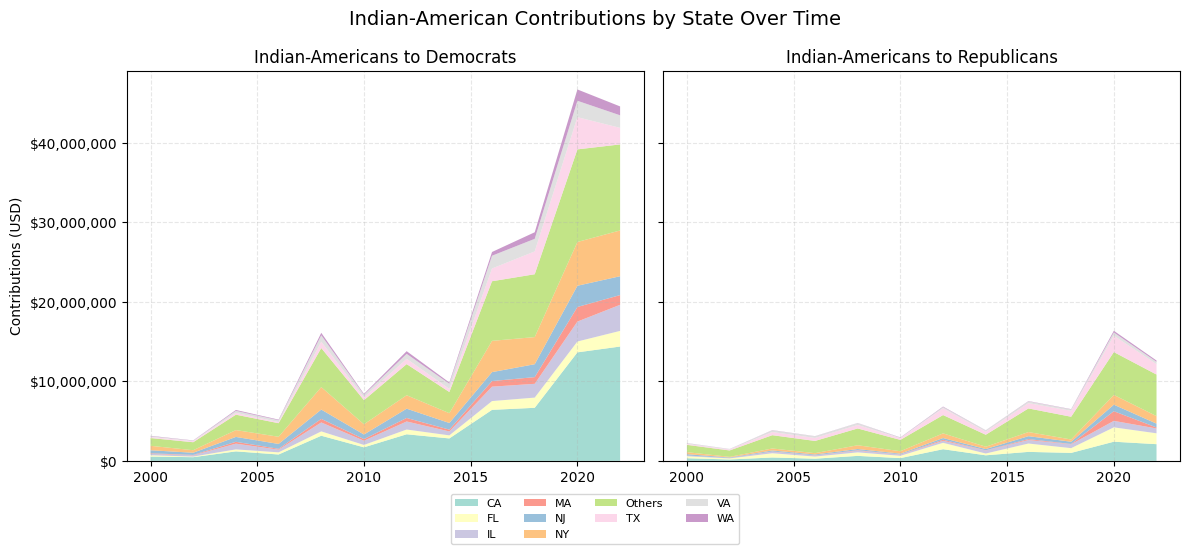

In [64]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

sum_indian_d = states_count_pivot.pivot(index='cycle', columns='state', values='sum_indian_d')
# sum_indian_d = sum_indian_d.div(sum_indian_d.sum(axis=1), axis=0) * 100
sum_indian_r = states_count_pivot.pivot(index='cycle', columns='state', values='sum_indian_r')
# sum_indian_r = sum_indian_r.div(sum_indian_r.sum(axis=1), axis=0) * 100

ax1.stackplot(
    sum_indian_d.index,
    sum_indian_d.T,
    labels=state_names,
    colors=colors,
    alpha=0.8,
)
ax1.set_title("Indian-Americans to Democrats", fontsize=12)
ax1.set_ylabel("Contributions (USD)")
# ax1.set_ylim(0, 100)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))
ax1.grid(True, linestyle='--', alpha=0.3)

ax2.stackplot(
    sum_indian_r.index,
    sum_indian_r.T,
    labels=state_names,
    colors=colors,
    alpha=0.8,
)
ax2.set_title("Indian-Americans to Republicans", fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.3)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=4,
    fontsize=8
)

plt.suptitle("Indian-American Contributions by State Over Time", fontsize=14)
plt.tight_layout()
plt.show()

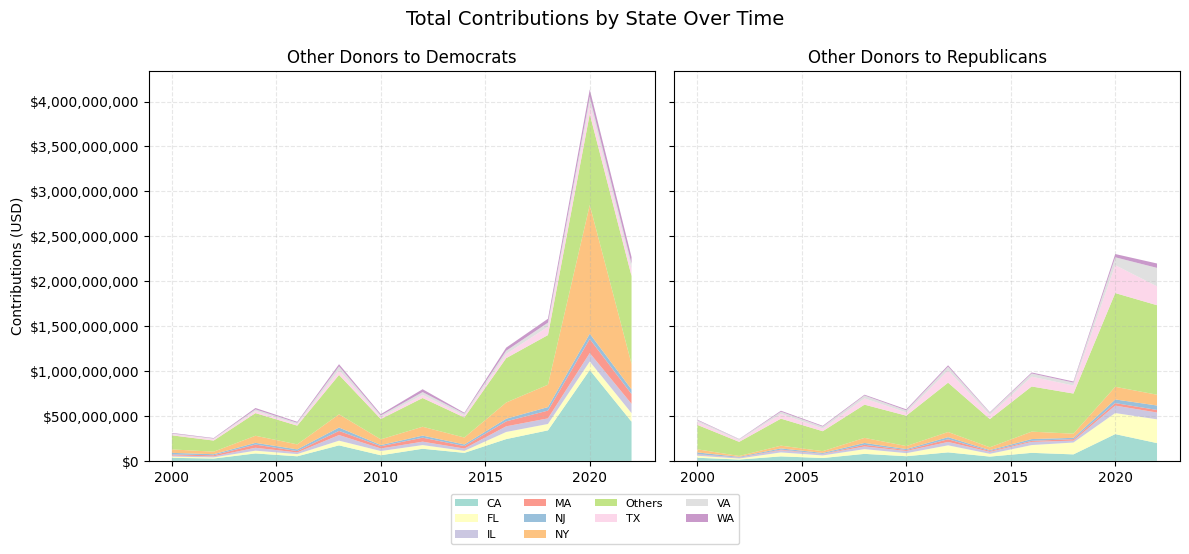

In [67]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

sum_other_d = states_count_pivot.pivot(index='cycle', columns='state', values='sum_other_d')
# sum_other_d = sum_other_d.div(sum_other_d.sum(axis=1), axis=0) * 100
sum_other_r = states_count_pivot.pivot(index='cycle', columns='state', values='sum_other_r')
# sum_other_r = sum_other_r.div(sum_other_r.sum(axis=1), axis=0) * 100

ax1.stackplot(
    sum_other_d.index,
    sum_other_d.T,
    labels=state_names,
    colors=colors,
    alpha=0.8,
)
ax1.set_title("Other Donors to Democrats", fontsize=12)
ax1.set_ylabel("Contributions (USD)")
# ax1.set_ylim(0, 100)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))
ax1.grid(True, linestyle='--', alpha=0.3)

ax2.stackplot(
    sum_other_r.index,
    sum_other_r.T,
    labels=state_names,
    colors=colors,
    alpha=0.8,
)
ax2.set_title("Other Donors to Republicans", fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.3)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=4,
    fontsize=8
)

plt.suptitle("Total Contributions by State Over Time", fontsize=14)
plt.tight_layout()
plt.show()